In [ ]:
! nvidia-smi

Thu Jun 15 18:11:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

from Model_2 import *
from utils import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train = datasets.MNIST('../data/MNIST', train=True, download=True, transform=train_transforms())
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test = datasets.MNIST('../data/MNIST', train=False, download=True, transform=test_transforms())
# The test part of the dataset is downloaded to ../data location

100%|██████████| 9912422/9912422 [00:00<00:00, 190348418.61it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 116701053.78it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68774464.71it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23260718.89it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = torch.device("cuda" if cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model.
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
# test till help to check accuracy of our model

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#return_image_stats(train)
# Since the train data is already Normalized, we will not get the actual mean and std values

torch.Size([128, 1, 28, 28])
torch.Size([128])


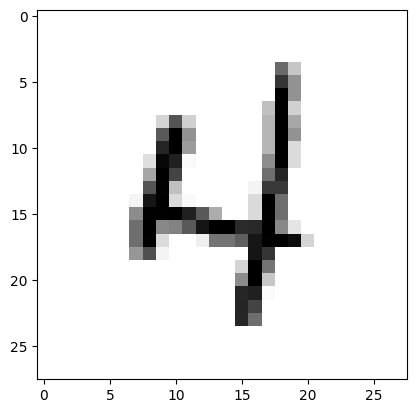

In [ ]:
return_single_image(train_loader)

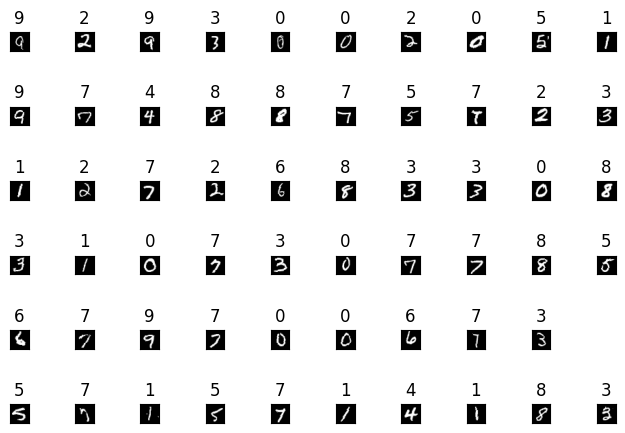

In [ ]:
return_dataset_images(train_loader,60)

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,600
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
           Dropout-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6           [-1, 32, 12, 12]           2,048
       BatchNorm2d-7           [-1, 32, 12, 12]              64
              ReLU-8           [-1, 32, 12, 12]               0
            Conv2d-9           [-1, 32, 10, 10]           9,216
      BatchNorm2d-10           [-1, 32, 10, 10]              64
             ReLU-11           [-1, 32, 10, 10]               0
           Conv2d-12           [-1, 10, 10, 10]             320
      BatchNorm2d-13           [-1, 10, 10, 10]              20
             ReLU-14           [-1, 10,

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.12944816052913666 Batch_id=468 Accuracy=93.17: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s]



Test set: Average loss: 0.1747, Accuracy: 9740/10000 (97.40%)

EPOCH: 2


Loss=0.07990150153636932 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]



Test set: Average loss: 0.1135, Accuracy: 9795/10000 (97.95%)

EPOCH: 3


Loss=0.12658829987049103 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]



Test set: Average loss: 0.0762, Accuracy: 9833/10000 (98.33%)

EPOCH: 4


Loss=0.07209267467260361 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]



Test set: Average loss: 0.0692, Accuracy: 9853/10000 (98.53%)

EPOCH: 5


Loss=0.04727132245898247 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]



Test set: Average loss: 0.0529, Accuracy: 9881/10000 (98.81%)

EPOCH: 6


Loss=0.05831392481923103 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]



Test set: Average loss: 0.0569, Accuracy: 9869/10000 (98.69%)

EPOCH: 7


Loss=0.034133948385715485 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s]



Test set: Average loss: 0.0595, Accuracy: 9842/10000 (98.42%)

EPOCH: 8


Loss=0.09295552968978882 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]



Test set: Average loss: 0.0465, Accuracy: 9877/10000 (98.77%)

EPOCH: 9


Loss=0.10339222103357315 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]



Test set: Average loss: 0.0473, Accuracy: 9874/10000 (98.74%)

EPOCH: 10


Loss=0.020907463505864143 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]



Test set: Average loss: 0.0635, Accuracy: 9816/10000 (98.16%)

EPOCH: 11


Loss=0.06316348165273666 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]



Test set: Average loss: 0.0451, Accuracy: 9879/10000 (98.79%)

EPOCH: 12


Loss=0.037566863000392914 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:21<00:00, 21.53it/s]



Test set: Average loss: 0.0434, Accuracy: 9887/10000 (98.87%)

EPOCH: 13


Loss=0.014396867714822292 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]



Test set: Average loss: 0.0434, Accuracy: 9884/10000 (98.84%)

EPOCH: 14


Loss=0.05047367513179779 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:21<00:00, 21.35it/s]



Test set: Average loss: 0.0467, Accuracy: 9866/10000 (98.66%)

EPOCH: 15


Loss=0.018366796895861626 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]



Test set: Average loss: 0.0350, Accuracy: 9907/10000 (99.07%)



In [ ]:
train_losses

[tensor(2.3337, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3132, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2674, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2082, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1660, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0696, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0236, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.9996, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.8805, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.8665, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.7747, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.7699, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.7188, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.5684, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.6072, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.5813, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

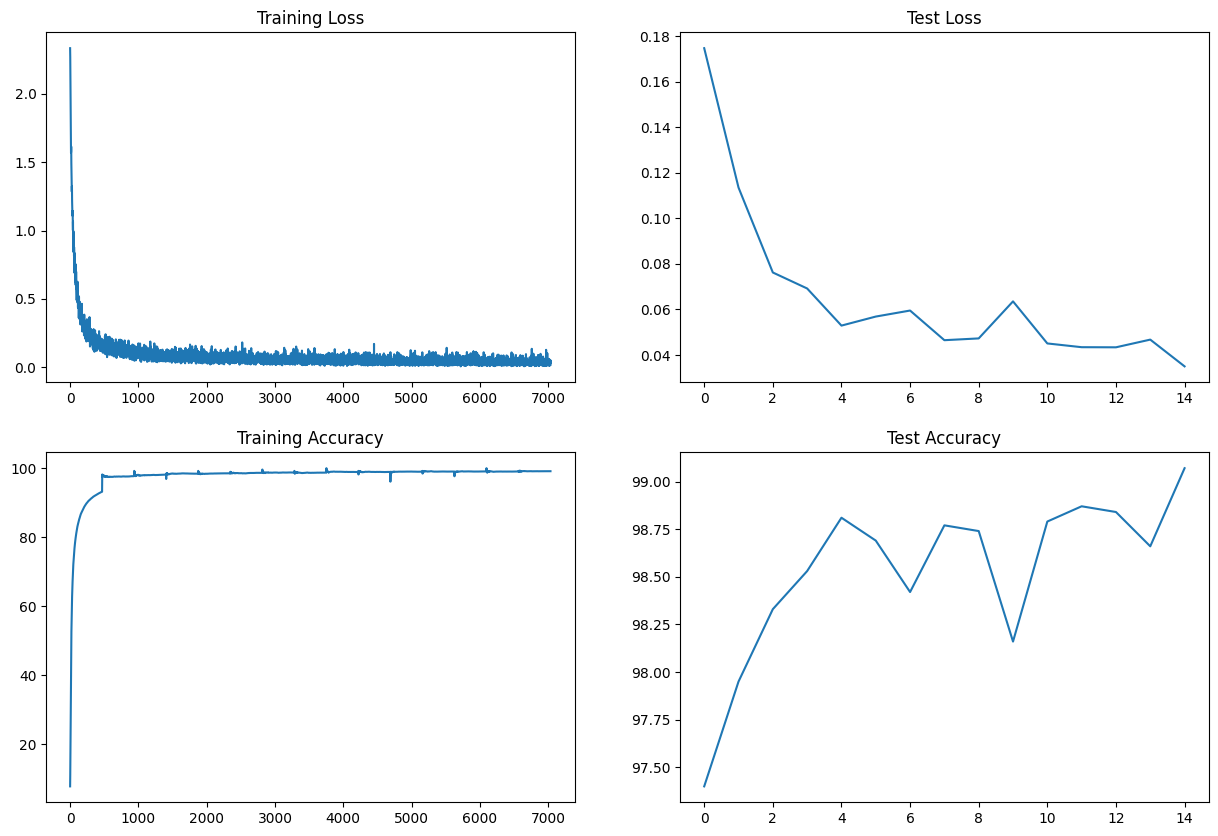

In [ ]:
draw_graphs(train_losses, train_acc, test_losses, test_acc)